In [1]:
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import os
from torch.utils.data import random_split

from urllib.request import urlretrieve
import json

import matplotlib.pyplot as plt
import PIL

2023-12-31 00:06:07.404823: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-31 00:06:07.481311: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# make trainset using /home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/train 
trainset = torchvision.datasets.ImageFolder(
    root='/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/train', 
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

# make valset using /home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/val 
valset = torchvision.datasets.ImageFolder(
    root='/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/val', 
    transform = transforms.Compose([
         transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [3]:
mini_batch_size = 256
# make trainloader
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=mini_batch_size, shuffle=True, num_workers=4
)

# make valloader
val_loader = torch.utils.data.DataLoader(
    valset, batch_size=mini_batch_size, shuffle=True, num_workers=4
)

In [4]:
# mini_batch_size = 256
print(f"mini_batch_size : {mini_batch_size}")

# check the size of trainset and valset
print(f"len(trainset) : {len(trainset)}") # the number of train images = 1,281,167
print(f"len(valset) : {len(valset)}")     # the number of val images   =    50,000

# check the size of train_loader and val_loader
print(f"len(train_loader) : {len(train_loader)}")  # the number of train batches = 5,005 (1,281,167 / mini_batch_size)
print(f"len(val_loader) : {len(val_loader)}")      # the number of val batches   =   196 (   50,000 / mini_batch_size)

mini_batch_size : 256
len(trainset) : 1281167
len(valset) : 50000
len(train_loader) : 5005
len(val_loader) : 196


In [5]:
num_train_examples = len(trainset)
num_val_examples = len(valset)
num_train_batch = len(train_loader) # the number of train batches = 5,005 (1,281,167 / mini_batch_size)
num_val_batch = len(val_loader)     # the number of val batches   =   196 (   50,000 / mini_batch_size)

print(f"# train examples : {num_train_examples}")
print(f"# val examples : {num_val_examples}")
print(f"# train batches : {num_train_batch}")
print(f"# val batches : {num_val_batch}")

# train examples : 1281167
# val examples : 50000
# train batches : 5005
# val batches : 196


In [6]:
# check the structure of train_loader
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([256, 3, 224, 224])
torch.Size([256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_constrictor', 'rock_python', 'Indian_cobra', 'green_mamba', 'sea_snake', 'horned_viper', 'diamondback', 

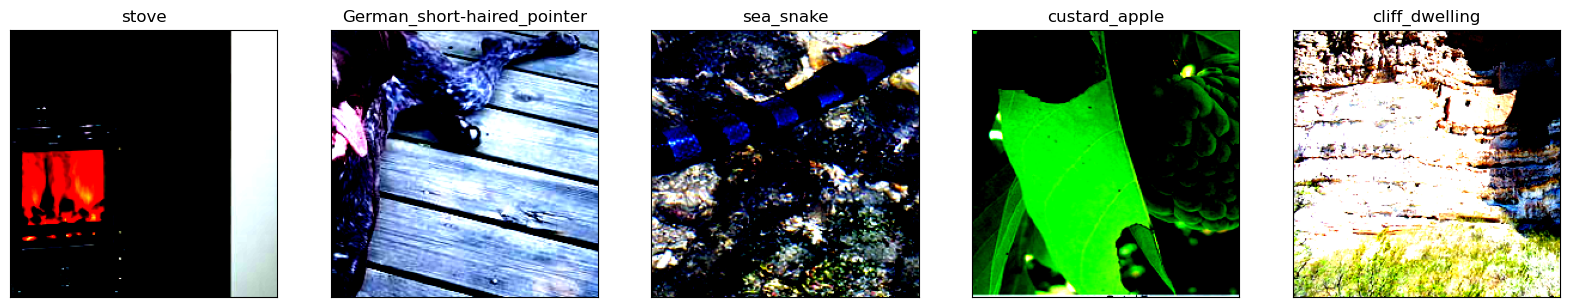

In [8]:
import random
import json

# 1000 classes
num_classes = 1000
with open('/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/imagenet_class_index.json') as f:
    class_index = json.load(f)
# Get the human-readable class names
class_names = [class_index[str(i)][1] for i in range(num_classes)]
# Print the class names
print(class_names)

writer = SummaryWriter('../runs/paper_bottleneck_resnet50_experiment1')
# check random 5 examples of trainset
fig = plt.figure(figsize=(20, 12))
for i, idx in enumerate(torch.randint(len(trainset), size=(5,))):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    image, label = trainset[idx]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(class_names[label])
    # record 5 examples of trainset to tensorboard
    writer.add_image(f"trainset_examples_{i}", image, label)
    

In [8]:
# training details
## randomly sample 224×224 crops for data augmentation.
## We use a mini-batch size of 256 images for fine-tuning
## The learning rate starts from 0.1 and is divided by 10 when the error plateaus, and the models are trained for up to 60 × 10^4 iterations.
## We use a weight decay of 0.0001 and a momentum of 0.9. We do not use dropout
## We initialize the learning rate for the pre-trained network to be 0.01
model = models.resnet50(pretrained=False, progress=True)
print(model.eval)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/home/hslee/anaconda3/envs/DL/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hslee/anaconda3/envs/DL/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<bound method Module.eval of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, ke